In [1]:
import math
from pandas_datareader import data as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
pd.options.mode.chained_assignment = None

#pip install tensorflow

2022-11-22 14:55:44.255675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 14:55:44.820261: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-22 14:55:46.129685: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-22 14:55:46.129974: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

# Modelo de deep learning baseado no histórico recente (LSTM)

In [2]:
acao = "MGLU3.SA"

inicio = "2014-12-31"
final = "2022-09-15"

dados_acao = pdr.get_data_yahoo(acao, inicio, final)

dados_acao

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,0.243750,0.231562,0.243750,0.232812,6323200.0,0.215259
2015-01-05,0.240625,0.229687,0.235625,0.237187,10326400.0,0.219304
2015-01-06,0.238437,0.233125,0.238437,0.234062,12572800.0,0.216414
2015-01-07,0.242187,0.234687,0.237500,0.241875,6454400.0,0.223638
2015-01-08,0.242187,0.237500,0.239375,0.240000,8393600.0,0.221905
...,...,...,...,...,...,...
2022-09-09,4.430000,4.300000,4.420000,4.380000,134934100.0,4.380000
2022-09-12,4.820000,4.430000,4.440000,4.790000,202900500.0,4.790000
2022-09-13,4.740000,4.410000,4.590000,4.700000,183348600.0,4.700000


In [3]:
#nao pode ser ajustados

cotacao = dados_acao['Close'].to_numpy().reshape(-1, 1)

cotacao

array([[0.232812  ],
       [0.237187  ],
       [0.234062  ],
       ...,
       [4.69999981],
       [4.46999979],
       [4.34000015]])

In [4]:
tamanho_dados_treinamento = int(len(cotacao) * 0.8)

tamanho_dados_treinamento

1532

In [5]:
#escalar os dados entre 0 e 1, para deixar mais fácil o processamento
#dados em escala pré definidas são mais fáceis de lidar. 

escalador = MinMaxScaler(feature_range=(0, 1))

dados_entre_0_e_1_treinamento = escalador.fit_transform(cotacao[0: tamanho_dados_treinamento, :])

dados_entre_0_e_1_teste = escalador.transform(cotacao[tamanho_dados_treinamento: , :])

dados_entre_0_e_1 = list(dados_entre_0_e_1_treinamento.reshape(
    len(dados_entre_0_e_1_treinamento))) + list(dados_entre_0_e_1_teste.reshape(len(dados_entre_0_e_1_teste)))
                                                

dados_entre_0_e_1 = np.array(dados_entre_0_e_1).reshape(len(dados_entre_0_e_1), 1)

In [6]:
dados_para_treinamento = dados_entre_0_e_1[0: tamanho_dados_treinamento, :]

#dados que serão usados para gerar o resultado
treinamento_x = []
#cotação que aconteceu de fato
treinamento_y = []


for i in range(60, len(dados_para_treinamento)):

    #60 ultimos dias
    treinamento_x.append(dados_para_treinamento[i - 60: i, 0])
    #cotacao
    treinamento_y.append(dados_para_treinamento[i, 0])

    if i <= 61:

        print(treinamento_x)
        print(treinamento_y)



[array([0.00737532, 0.00753488, 0.00742091, 0.00770585, 0.00763747,
       0.00734115, 0.00743232, 0.00734115, 0.00720438, 0.00718159,
       0.00724997, 0.00720438, 0.00686247, 0.00691944, 0.00688527,
       0.00691944, 0.00686247, 0.00663453, 0.00641797, 0.0066915 ,
       0.00663453, 0.00668012, 0.006361  , 0.00628121, 0.00617865,
       0.00582532, 0.00575694, 0.00588233, 0.00549483, 0.0056088 ,
       0.00582532, 0.00585953, 0.00613306, 0.00612165, 0.00620145,
       0.00640659, 0.00622424, 0.0063838 , 0.00577974, 0.00581395,
       0.00558601, 0.00520988, 0.0051415 , 0.00495915, 0.00466283,
       0.00491356, 0.00486797, 0.00515292, 0.00487939, 0.00469704,
       0.00462865, 0.00457165, 0.00468562, 0.00470842, 0.00470842,
       0.00466283, 0.00458307, 0.00456027, 0.00452606, 0.00462865])]
[0.004685621274704243]
[array([0.00737532, 0.00753488, 0.00742091, 0.00770585, 0.00763747,
       0.00734115, 0.00743232, 0.00734115, 0.00720438, 0.00718159,
       0.00724997, 0.00720438, 0.00

In [7]:
#transformando as listas em arrays e dando reshape 3d 

treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)

treinamento_x

treinamento_x = treinamento_x.reshape(treinamento_x.shape[0], treinamento_x.shape[1], 1)

treinamento_x

array([[[0.00737532],
        [0.00753488],
        [0.00742091],
        ...,
        [0.00456027],
        [0.00452606],
        [0.00462865]],

       [[0.00753488],
        [0.00742091],
        [0.00770585],
        ...,
        [0.00452606],
        [0.00462865],
        [0.00468562]],

       [[0.00742091],
        [0.00770585],
        [0.00763747],
        ...,
        [0.00462865],
        [0.00468562],
        [0.00485659]],

       ...,

       [[0.88110614],
        [0.85156498],
        [0.83332972],
        ...,
        [0.87600022],
        [0.88074142],
        [0.89423547]],

       [[0.85156498],
        [0.83332972],
        [0.83952971],
        ...,
        [0.88074142],
        [0.89423547],
        [0.88402378]],

       [[0.83332972],
        [0.83952971],
        [0.84864734],
        ...,
        [0.89423547],
        [0.88402378],
        [0.91502372]]])

In [8]:
#construindo o modelo

modelo = Sequential()

#vamos criar um modelo com 50 neurônios
#return sequences = True pois vamos usar outro LSTM depois.
#definir o shape, que no caso são 60 informações para gerar uma.
#Adicionar mais neurônios com o dense, 25 e 1
#Não se apegue a isso agora, é apenas um arquitetura de deep learning.

modelo.add(LSTM(50, return_sequences=True, input_shape = (treinamento_x.shape[1], 1)))
modelo.add(LSTM(50, return_sequences=False))
modelo.add(Dense(25))
modelo.add(Dense(1))


2022-11-22 14:56:31.083087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-22 14:56:31.276252: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-11-22 14:56:31.276275: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-22 14:56:31.277532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

In [9]:
#copilando o modelo

# a função de loss é a forma de medir o erro do modelo, que nesse caso
#é o classico erro médio quadrático da que é usado em regressão linear
#otimizador e medida de erro

modelo.compile(optimizer="adam", loss="mean_squared_error") 

In [10]:
#agora com o modelo copilado e os dados, podemos treinar o modelo

modelo.fit(treinamento_x, treinamento_y, batch_size=1, epochs=1)

1472/1472 [==============================] - 86s 57ms/step - loss: 0.0020


In [11]:
#criar dados de teste

dados_teste = dados_entre_0_e_1[tamanho_dados_treinamento - 60:, :]

teste_x = []
teste_y = cotacao[tamanho_dados_treinamento: , :] 

for i in range(60, len(dados_teste)):
    teste_x.append(dados_teste[i - 60: i, 0])
    

In [12]:
#reshape
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

In [13]:
#pegando predições do modelo

predicoes = modelo.predict(teste_x)

#tirando a escala dos dados

predicoes = escalador.inverse_transform(predicoes)

predicoes

12/12 [==============================] - 1s 24ms/step


array([[27.557291 ],
       [27.617306 ],
       [27.515072 ],
       [27.370472 ],
       [27.329317 ],
       [27.326687 ],
       [27.33187  ],
       [27.27381  ],
       [27.227535 ],
       [27.167572 ],
       [26.967745 ],
       [26.717308 ],
       [26.418875 ],
       [26.082233 ],
       [25.654099 ],
       [25.206013 ],
       [24.748669 ],
       [24.292534 ],
       [23.905954 ],
       [23.599092 ],
       [23.378044 ],
       [23.222008 ],
       [23.132675 ],
       [23.053717 ],
       [23.131187 ],
       [23.266878 ],
       [23.430864 ],
       [23.64714  ],
       [23.867714 ],
       [24.08334  ],
       [24.25621  ],
       [24.370914 ],
       [24.440062 ],
       [24.438667 ],
       [24.447252 ],
       [24.452795 ],
       [24.393265 ],
       [24.281168 ],
       [24.11423  ],
       [23.909452 ],
       [23.709925 ],
       [23.489456 ],
       [23.288555 ],
       [23.074802 ],
       [22.908571 ],
       [22.720585 ],
       [22.549585 ],
       [22.33

In [14]:
#pegando o erro médio quadrático (RMSE)

rmse = np.sqrt(np.mean(predicoes - teste_y) ** 2)
rmse

1.7581822605182726

In [15]:
#criando o grafico do modelo


treinamento = dados_acao.iloc[:tamanho_dados_treinamento, :]
df_teste = pd.DataFrame({"Close": dados_acao['Close'].iloc[tamanho_dados_treinamento:],
                        "predicoes": predicoes.reshape(len(predicoes))})


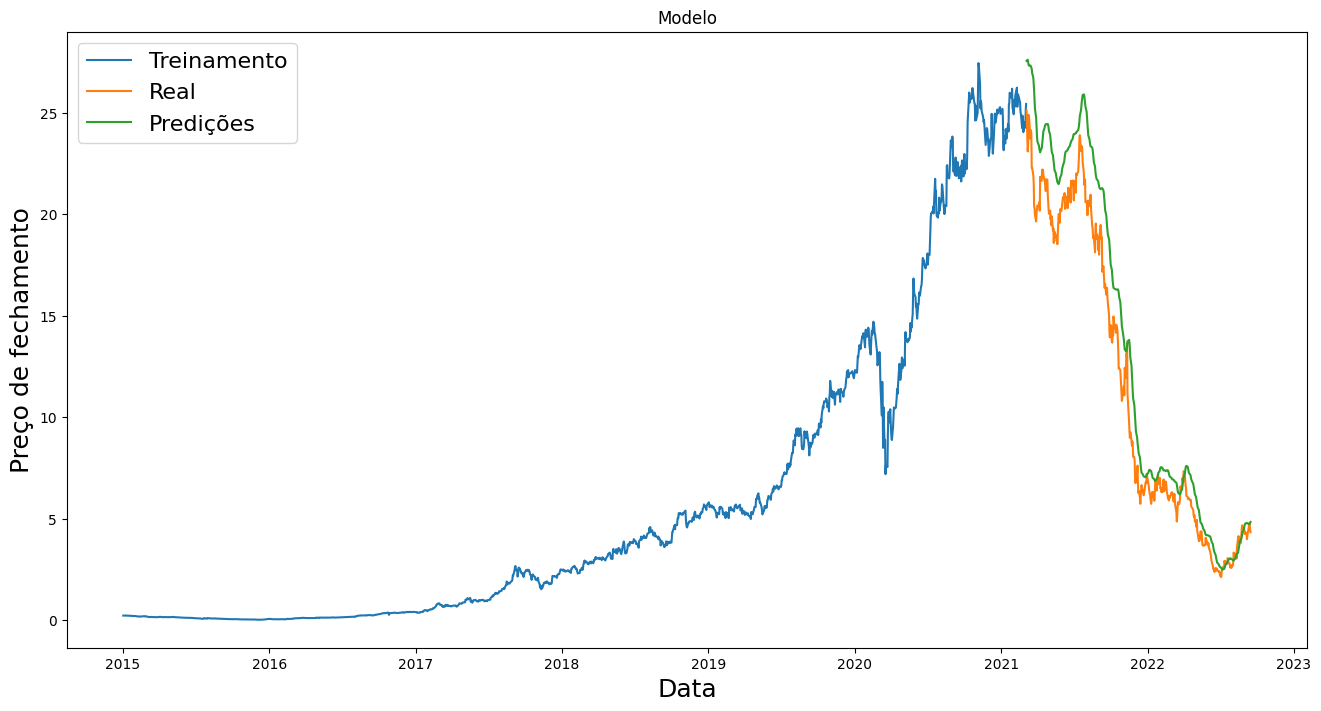

In [16]:
plt.figure(figsize =(16, 8))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 18)
plt.ylabel("Preço de fechamento", fontsize = 18)
plt.plot(treinamento['Close'])
plt.plot(df_teste[['Close', 'predicoes']])
plt.legend(['Treinamento', 'Real', 'Predições'], loc=2, prop={'size': 16})
plt.show()

In [17]:
df_teste.sort_index()

df_teste

,Close,predicoes
Date,,
2021-03-05,25.129999,27.557291
2021-03-08,23.100000,27.617306
2021-03-09,23.389999,27.515072
2021-03-10,24.900000,27.370472
2021-03-11,24.799999,27.329317
...,...,...
2022-09-09,4.380000,4.752660
2022-09-12,4.790000,4.742321
2022-09-13,4.700000,4.770107


In [19]:
#o preço é legal, mas o importante é acertar pra qual mercado o lado vai. Sera q isso foi feito?

#calcular media de acertos e expectativa de lucro

df_teste['variacao_percentual_acao'] = df_teste['Close'].pct_change()
df_teste['variacao_percentual_modelo'] = df_teste['predicoes'].pct_change()

df_teste = df_teste.dropna()

df_teste['var_acao_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_acao'] > 0, 
                                                      True, False)
df_teste['var_modelo_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_modelo'] > 0, 
                                                      True, False)

df_teste['acertou_o_lado'] = np.where(df_teste['var_acao_maior_menor_que_zero'] == df_teste['var_modelo_maior_menor_que_zero']
                                      , True, False)

df_teste['variacao_percentual_acao_abs'] = df_teste['variacao_percentual_acao'].abs()

df_teste

,Close,predicoes,variacao_percentual_acao,variacao_percentual_modelo,var_acao_maior_menor_que_zero,var_modelo_maior_menor_que_zero,acertou_o_lado,variacao_percentual_acao_abs
Date,,,,,,,,
2021-03-09,23.389999,27.515072,0.012554,-0.003702,True,False,False,0.012554
2021-03-10,24.900000,27.370472,0.064558,-0.005255,True,False,False,0.064558
2021-03-11,24.799999,27.329317,-0.004016,-0.001504,False,False,True,0.004016
2021-03-12,24.570000,27.326687,-0.009274,-0.000096,False,False,True,0.009274
2021-03-15,23.719999,27.331869,-0.034595,0.000190,False,True,False,0.034595
...,...,...,...,...,...,...,...,...
2022-09-09,4.380000,4.752660,0.020979,-0.004367,True,False,False,0.020979
2022-09-12,4.790000,4.742321,0.093607,-0.002175,True,False,False,0.093607
2022-09-13,4.700000,4.770107,-0.018789,0.005859,False,True,False,0.018789


In [20]:
acertou_lado = df_teste['acertou_o_lado'].sum()/len(df_teste['acertou_o_lado'])
errou_lado = 1 - acertou_lado

media_lucro = df_teste.groupby('acertou_o_lado')['variacao_percentual_acao_abs'].mean()

exp_mat_lucro = acertou_lado * media_lucro[1] - media_lucro[0] * errou_lado

ganho_sobre_perda = media_lucro[1]/media_lucro[0]

print(media_lucro)
print(ganho_sobre_perda)
print(acertou_lado)
print(exp_mat_lucro * 100)

acertou_o_lado
False    0.033231
True     0.033790
Name: variacao_percentual_acao_abs, dtype: float64
1.016818968737047
0.5104712041884817
0.09812427713810114


In [21]:
#criando um código que você passa 60 dias e ele devolve a cotação
#resumindo: vamos descobrir o preço da petrobras de hoje/amanha com esse modelo

data_hoje = datetime.now()

#se quiser escolher um dia, basta fazer assim

data_hoje = datetime.now() - timedelta(days = 1)

if data_hoje.hour > 18:
    
    final = data_hoje
    inicial = datetime.now() - timedelta(days = 252)
    
else:
    final = data_hoje - timedelta(days = 1)
    inicial = datetime.now() - timedelta(days = 252)
    
#nao vai botar outra ação aqui hein kkkkkkkk
cotacoes = pdr.get_data_yahoo(acao, inicial, final) 
ultimos_60_dias = cotacoes['Close'].iloc[-60:].values.reshape(-1, 1)

ultimos_60_dias_escalado = escalador.transform(ultimos_60_dias)

teste_x = []
teste_x.append(ultimos_60_dias_escalado)
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

previsao_de_preco = modelo.predict(teste_x)
previsao_de_preco = escalador.inverse_transform(previsao_de_preco)

print(previsao_de_preco)

1/1 [==============================] - 1s 518ms/step
[[4.266885]]


# Sugestões:
<br>

- Melhorar as estatísticas de avaliação (dias seguidos ganhando, max DD, etc)
<br>

- Rodar pra todas as ações do ibovespa e criar uma expectativa matemática da expectativa matemática. Isso vai deixar o resultado final ainda mais robusto, definando a aloção do $ basedo na liquidez


In [22]:
dados_acao

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,0.243750,0.231562,0.243750,0.232812,6323200.0,0.215259
2015-01-05,0.240625,0.229687,0.235625,0.237187,10326400.0,0.219304
2015-01-06,0.238437,0.233125,0.238437,0.234062,12572800.0,0.216414
2015-01-07,0.242187,0.234687,0.237500,0.241875,6454400.0,0.223638
2015-01-08,0.242187,0.237500,0.239375,0.240000,8393600.0,0.221905
...,...,...,...,...,...,...
2022-09-09,4.430000,4.300000,4.420000,4.380000,134934100.0,4.380000
2022-09-12,4.820000,4.430000,4.440000,4.790000,202900500.0,4.790000
2022-09-13,4.740000,4.410000,4.590000,4.700000,183348600.0,4.700000
